In [1]:
import json

In [2]:
import pandas as pd
pd.set_option('display.max_rows', 20)

In [3]:
import utils.checker as check
import utils.presenter as show
import utils.schedule_solver__with_arrivals as ssv

import utils.converter as convert

In [4]:
import utils.rolling_planning as rp

In [5]:
from ProductionDaySimulation import ProductionDaySimulation

In [6]:
import utils.schedule_solver__rescheduling as re_ssv
import utils.schedule_solver__with_deadlines as ssv_dead

In [7]:
# Datei laden
with open("data/jobshop_instances.json", "r", encoding="utf-8") as f:
    jobshop_instances = json.load(f)

instance =  jobshop_instances["instance ft10"]
show.print_jobs(instance)

job 0:  [[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
job 1:  [[0, 43], [2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
job 2:  [[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
job 3:  [[1, 81], [2, 95], [0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
job 4:  [[2, 14], [0, 6], [1, 22], [5, 61], [3, 26], [4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
job 5:  [[2, 84], [1, 2], [5, 52], [3, 95], [8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
job 6:  [[1, 46], [0, 37], [3, 61], [2, 13], [6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
job 7:  [[2, 31], [0, 86], [1, 46], [5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
job 8:  [[0, 76], [1, 69], [3, 76], [5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
job 9:  [[1, 85], [0, 13], [2, 61], [6, 7], [8, 64], [9, 76], [5, 47], [3, 52], [4, 90], [7, 45]]



In [8]:
def solve_jssp_sum_tardiness_with_fixed_operations(
    job_dict,
    df_arrivals_deadlines,
    df_executed,
    solver_time_limit=300,
    epsilon=0.0,
    arrival_column="Arrival",
    deadline_column="Deadline",
    reschedule_start=1440,
):
    """
    Schnelle Rescheduling-Variante mit fixierten Operationen.
    Plant alle verbleibenden Jobs ab ``reschedule_start`` und minimiert die
    *Summe der Tardiness* (∑ max(0, Endzeit_j − Deadline_j)).

    Parameter
    ---------
    job_dict : dict[str, list[tuple[int, float]]]
        Jede Zeile beschreibt einen Job und seine technologische Reihenfolge
        als Liste von Tupeln ``(MachineID, Dauer)``.
    df_arrivals_deadlines : pandas.DataFrame
        Enthält mindestens die Spalten ``Job``, ``arrival_column`` und
        ``deadline_column``.
    df_executed : pandas.DataFrame
        Bereits ausgeführter (oder fest verplanter) Teil des Zeitplans mit
        Spalten ``Job``, ``Machine``, ``Start`` und ``End``.
    solver_time_limit : int, optional
        Zeitlimit für den HiGHS‑Solver in Sekunden, Standard 300 s.
    epsilon : float, optional
        Kleiner Puffer zur Vermeidung von Rundungs‑/Konfliktproblemen.
    arrival_column : str, optional
        Name der Spalte mit den Ankunftszeiten.
    deadline_column : str, optional
        Name der Spalte mit den Deadlines.
    reschedule_start : float, optional
        Zeitpunkt, ab dem neu geplant werden soll (z. B. in Minuten).

    Returns
    -------
    tuple[pandas.DataFrame, float]
        • Ein DataFrame mit dem neuen Zeitplan (inkl. Tardiness je Job)
        • Die Gesamt‑Tardiness des Plans
    """

    import pulp
    import pandas as pd

    print(f"🔁 Starte Rescheduling (Tardiness) ab t = {reschedule_start}")

    # Datenvorbereitung
    df_arrivals_deadlines = (
        df_arrivals_deadlines
        .sort_values(arrival_column)
        .reset_index(drop=True)
    )
    arrival_times = (
        df_arrivals_deadlines.set_index("Job")[arrival_column].to_dict()
    )
    deadlines = (
        df_arrivals_deadlines.set_index("Job")[deadline_column].to_dict()
    )

    job_names = list(
        df_arrivals_deadlines.sort_values(arrival_column, ascending=False)[
            "Job"
        ]
    )
    num_jobs = len(job_names)

    all_ops = [job_dict[job] for job in job_names]
    all_machines = {mach for job in all_ops for mach, _ in job}

    print(f"🔹 {num_jobs} Jobs erkannt")

    # Letzte Endzeit bereits realisierter Operationen je Job
    last_executed_end = df_executed.groupby("Job")["End"].max().to_dict()

    # Fixierte Operationen ab reschedule_start (werden wie Sperrblöcke behandelt)
    df_executed = df_executed[df_executed["End"] >= reschedule_start].copy()
    df_executed["MachineID"] = (
        df_executed["Machine"].str.extract(r"M(\d+)").astype(int)
    )
    fixed_ops_dict = {
        m: list(zip(gr["Start"], gr["End"], gr["Job"]))
        for m, gr in df_executed.groupby("MachineID")
    }

    # LP‑Modell
    prob = pulp.LpProblem("FastJSSP_Tardiness", pulp.LpMinimize)

    # Startzeit‑Variablen
    starts = {
        (j, o): pulp.LpVariable(f"start_{j}_{o}", lowBound=0, cat="Continuous")
        for j in range(num_jobs)
        for o in range(len(all_ops[j]))
    }

    # Endzeit‑ & Tardiness‑Variablen je Job
    job_ends = {
        j: pulp.LpVariable(f"job_end_{j}", lowBound=0, cat="Continuous")
        for j in range(num_jobs)
    }
    tardiness = {
        j: pulp.LpVariable(f"tardiness_{j}", lowBound=0, cat="Continuous")
        for j in range(num_jobs)
    }

    # Zielfunktion: Summe der Tardiness
    prob += pulp.lpSum(tardiness[j] for j in range(num_jobs))

    # Nebenbedingungen 
    # Technologische Reihenfolge + frühestmöglicher Start
    for j, job_name in enumerate(job_names):
        job_ops = job_dict[job_name]
        earliest_start = max(
            arrival_times[job_name],
            last_executed_end.get(job_name, reschedule_start),
            reschedule_start,
        )
        prob += starts[(j, 0)] >= earliest_start
        for o in range(1, len(job_ops)):
            dur_prev = job_ops[o - 1][1]
            prob += starts[(j, o)] >= starts[(j, o - 1)] + dur_prev

    # Maschinen‑Disjunktivität
    bigM = 1e5
    for m in sorted(all_machines):
        ops_m = [
            (j, o, d)
            for j in range(num_jobs)
            for o, (mach, d) in enumerate(all_ops[j])
            if mach == m
        ]

        # — Konflikte zwischen neu zu planenden Ops —
        for i in range(len(ops_m)):
            j1, o1, d1 = ops_m[i]
            for j2, o2, d2 in ops_m[i + 1 :]:
                if j1 == j2:
                    continue  # gleicher Job – wird durch Technologie abgedeckt
                y = pulp.LpVariable(f"y_{j1}_{o1}_{j2}_{o2}", cat="Binary")
                prob += (
                    starts[(j1, o1)] + d1 + epsilon
                    <= starts[(j2, o2)] + bigM * (1 - y)
                )
                prob += (
                    starts[(j2, o2)] + d2 + epsilon
                    <= starts[(j1, o1)] + bigM * y
                )

        # — Konflikte mit fixierten Ops (Sperrblöcke) —
        for j1, o1, d1 in ops_m:
            for fixed_start, fixed_end, fixed_job in fixed_ops_dict.get(m, []):
                y_fix = pulp.LpVariable(
                    f"y_fix_{j1}_{o1}_{fixed_job}", cat="Binary"
                )
                prob += (
                    starts[(j1, o1)] + d1 + epsilon
                    <= fixed_start + bigM * (1 - y_fix)
                )
                prob += (
                    fixed_end + epsilon
                    <= starts[(j1, o1)] + bigM * y_fix
                )

    # Job‑Endzeit & Tardiness‑Definition
    for j, job_name in enumerate(job_names):
        last_op = len(all_ops[j]) - 1
        prob += job_ends[j] == starts[(j, last_op)] + all_ops[j][last_op][1]
        prob += tardiness[j] >= job_ends[j] - deadlines[job_name]

    # Solver
    solver = pulp.HiGHS_CMD(msg=True, timeLimit=solver_time_limit)
    prob.solve(solver)

    # Ergebnisaufbereitung
    schedule_rows: list[dict] = []
    for (j, o), var in sorted(starts.items()):
        start_val = var.varValue
        if start_val is None:
            continue
        machine, duration = all_ops[j][o]
        schedule_rows.append(
            {
                "Job": job_names[j],
                "Machine": f"M{machine}",
                "Start": round(start_val, 2),
                "Processing Time": duration,
                "End": round(start_val + duration, 2),
            }
        )

    df_schedule = pd.DataFrame(schedule_rows)
    df_schedule["Arrival"] = df_schedule["Job"].map(arrival_times)
    df_schedule["Deadline"] = df_schedule["Job"].map(deadlines)
    df_schedule["Tardiness"] = (
        df_schedule.groupby("Job")["End"].transform("max") - df_schedule["Deadline"]
    ).clip(lower=0)

    df_schedule = df_schedule[
        [
            "Job",
            "Arrival",
            "Deadline",
            "Machine",
            "Start",
            "Processing Time",
            "End",
            "Tardiness",
        ]
    ]

    total_tardiness = round(pulp.value(prob.objective), 3)
    print(
        f"✅ Rescheduling abgeschlossen | Gesamt‑Tardiness = {total_tardiness}"
    )

    return df_schedule, total_tardiness


In [9]:
minutes = 50

## Day 0

In [10]:
jssp_data, df_times = rp.init_jobs_with_arrivals(instance, 3, u_b_mmax = 0.75, 
                                                    generate_deadlines = True, deadlines_buffer_factor= 1.9)
show.print_jobs(jssp_data)

Job_000:  [[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
Job_001:  [[0, 43], [2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
Job_002:  [[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
Job_003:  [[1, 81], [2, 95], [0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
Job_004:  [[2, 14], [0, 6], [1, 22], [5, 61], [3, 26], [4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
Job_005:  [[2, 84], [1, 2], [5, 52], [3, 95], [8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
Job_006:  [[1, 46], [0, 37], [3, 61], [2, 13], [6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
Job_007:  [[2, 31], [0, 86], [1, 46], [5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
Job_008:  [[0, 76], [1, 69], [3, 76], [5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
Job_009:  [[1, 85], [0, 13], [2, 61], [6, 7], [8, 64], [9, 76], [5, 47], [3, 52], [4, 90], [7, 4

In [11]:
df_times 

,Job,Arrival,Deadline
0,Job_000,14.37,2362.556555
1,Job_001,116.28,3148.115805
2,Job_002,141.78,3518.412818
3,Job_003,192.34,4086.168337
4,Job_004,236.45,2572.747002
...,...,...,...
64,Job_064,3749.15,6085.447002
65,Job_065,3907.00,7111.234311
66,Job_066,4061.64,6409.826555
67,Job_067,4110.12,7141.955805


### 1) Scheduling

In [12]:
df_plan0 = ssv_dead.solve_jssp_sum_tardiness(jssp_data, df_times, solver_time_limit=60*minutes, epsilon=0.06)
check.check_all_constraints(df_plan0, jssp_data)

Running HiGHS 1.10.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
Set option time_limit to 3000
Set option solution_file to "/var/folders/88/5n59t5yx3095jhz9lldbm0kr0000gn/T/ce13eac4ffe54b82836b6cb8fb42af55-pulp.sol"
Set option log_file to "/var/folders/88/5n59t5yx3095jhz9lldbm0kr0000gn/T/ce13eac4ffe54b82836b6cb8fb42af55-pulp.HiGHS_log"
Set option write_solution_to_file to true
Number of BV entries in BOUNDS section is 23460
MIP  ce13eac4ffe54b82836b6cb8fb42af55-pulp has 47748 rows; 24288 cols; 142347 nonzeros; 23460 integer variables (23460 binary)
Coefficient ranges:
  Matrix [1e+00, 1e+05]
  Cost   [1e+00, 1e+00]
  Bound  [1e+00, 1e+00]
  RHS    [2e+00, 1e+05]
Presolving model
47610 rows, 24219 cols, 142140 nonzeros  0s
24150 rows, 24219 cols, 71760 nonzeros  0s
24150 rows, 24219 cols, 71760 nonzeros  0s

Solving MIP model with:
   24150 rows
   24219 cols (23460 binary, 0 integer, 0 implied int., 759 continuous)
   71760 nonzeros

Src: B => Branching; C => Cent

True

In [13]:
print(f"Globale Makespan:{max(df_plan0.End)}")
df_plan0

Globale Makespan:8761.08


,Job,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,Job_068,4210.59,7587.222818,M1,7663.78,91,7754.78,1173.857182
1,Job_068,4210.59,7587.222818,M0,7754.78,85,7839.78,1173.857182
2,Job_068,4210.59,7587.222818,M3,7992.78,39,8031.78,1173.857182
3,Job_068,4210.59,7587.222818,M2,8031.78,74,8105.78,1173.857182
4,Job_068,4210.59,7587.222818,M8,8472.02,90,8562.02,1173.857182
...,...,...,...,...,...,...,...,...
685,Job_000,14.37,2362.556555,M5,215.37,11,226.37,0.000000
686,Job_000,14.37,2362.556555,M6,226.37,62,288.37,0.000000
687,Job_000,14.37,2362.556555,M7,288.37,56,344.37,0.000000
688,Job_000,14.37,2362.556555,M8,344.37,44,388.37,0.000000


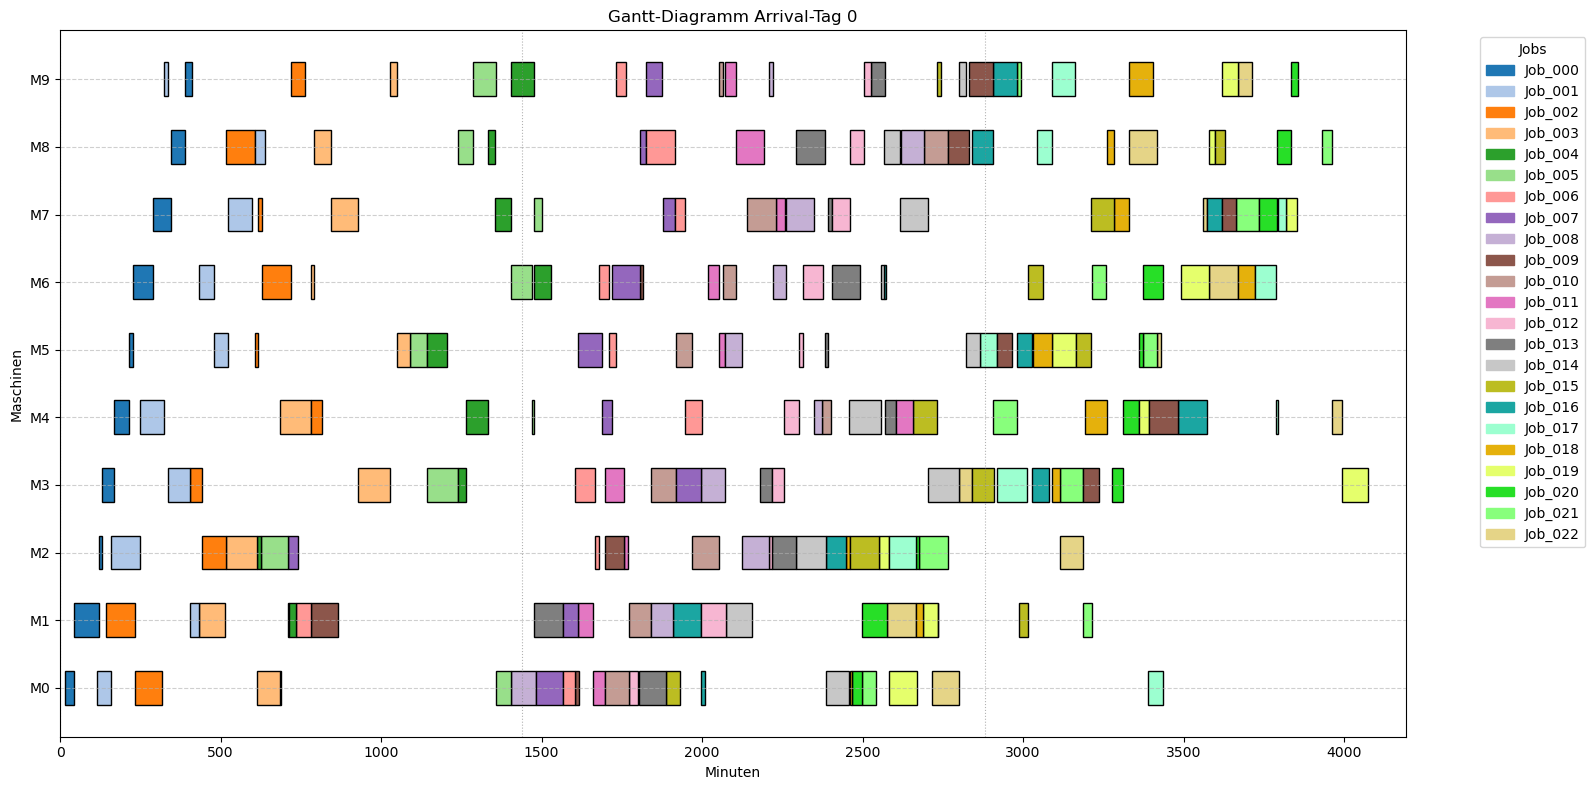

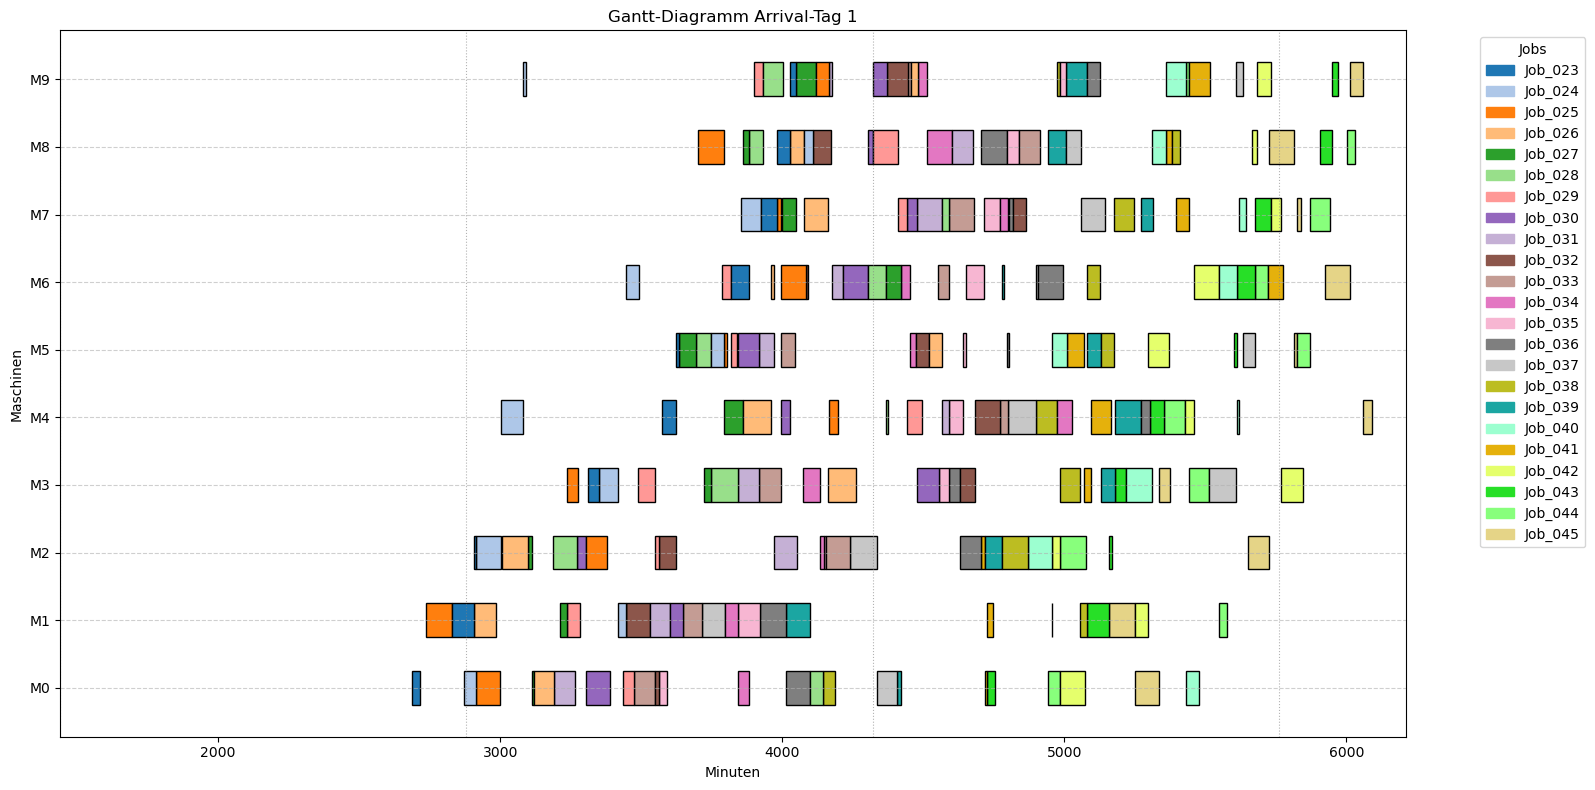

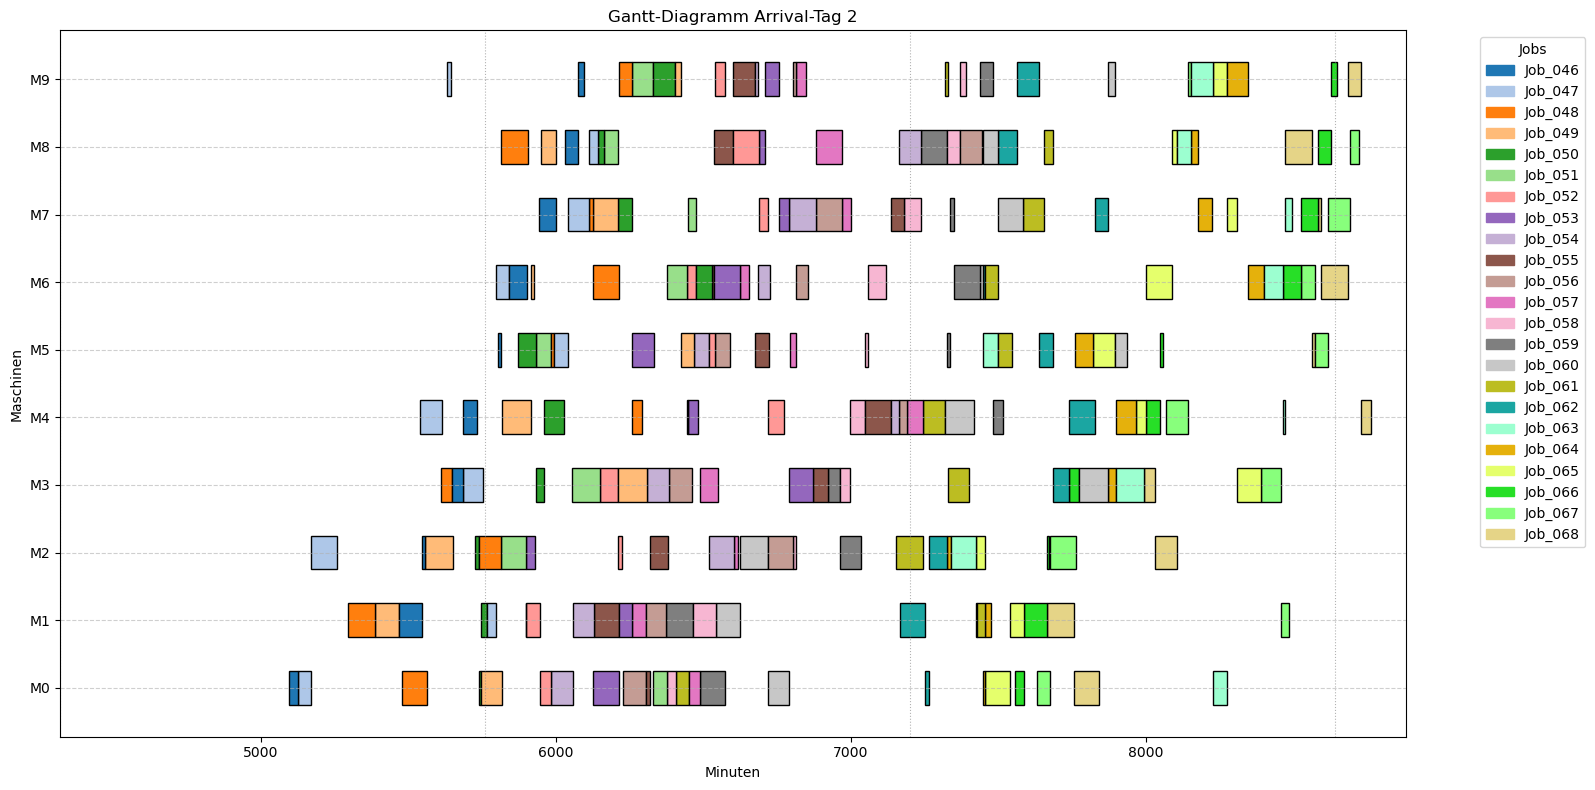

In [14]:
df = df_plan0

block = 1440                                        
for idx, part_df in df.groupby(df['Arrival'] // block, sort=True):
    show.plot_gantt_machines(part_df, f"Gantt-Diagramm Arrival-Tag {int(idx)}")

### 2) Simulation für Tag 0

In [15]:
day_start = 0
day_end = 1440

filt = (df_plan0["Start"] >=  day_start) & (df_plan0["Start"] < day_end)
df_schedule_0 = df_plan0[filt]
df_schedule_0

,Job,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
590,Job_009,529.40,3739.579087,M1,780.70,85,865.70,0.0
600,Job_008,427.52,3976.551324,M0,1405.52,76,1481.52,0.0
610,Job_007,409.92,3614.154311,M2,710.58,31,741.58,0.0
620,Job_006,389.61,2862.636852,M1,734.64,46,780.64,0.0
630,Job_005,316.00,3264.608939,M2,626.52,84,710.52,0.0
...,...,...,...,...,...,...,...,...
685,Job_000,14.37,2362.556555,M5,215.37,11,226.37,0.0
686,Job_000,14.37,2362.556555,M6,226.37,62,288.37,0.0
687,Job_000,14.37,2362.556555,M7,288.37,56,344.37,0.0
688,Job_000,14.37,2362.556555,M8,344.37,44,388.37,0.0


In [16]:
simulation = ProductionDaySimulation(df_schedule_0, vc=0.25)
df_execution, df_undone = simulation.run(end_time=day_end)

[00:14:22] Job_000 started on M0
[00:36:34] Job_000 finished on M0 (after 22 minutes 13 seconds)
[00:43:22] Job_000 started on M1
[01:34:22] Job_000 finished on M1 (after 51 minutes)
[01:56:16] Job_001 started on M0
[02:01:22] Job_000 started on M2
[02:10:31] Job_000 finished on M2 (after 09 minutes 09 seconds)
[02:10:31] Job_000 started on M3
[02:21:46] Job_002 started on M1
[02:53:19] Job_001 finished on M0 (after 57 minutes 03 seconds)
[02:53:19] Job_001 started on M2
[03:23:48] Job_000 finished on M3 (after 73 minutes 17 seconds)
[03:23:48] Job_000 started on M4
[03:31:40] Job_002 finished on M1 (after 69 minutes 53 seconds)
[03:52:46] Job_002 started on M0
[04:13:35] Job_000 finished on M4 (after 49 minutes 47 seconds)
[04:13:35] Job_000 started on M5
[04:26:19] Job_001 finished on M2 (after 93 minutes)
[04:26:19] Job_001 started on M4
[04:27:02] Job_000 finished on M5 (after 13 minutes 26 seconds)
[04:27:02] Job_000 started on M6
[05:25:40] Job_000 finished on M6 (after 58 minute

In [17]:
df_execution

,Job,Arrival,Machine,Start,Simulated Processing Time,Flow time,End
0,Job_000,14.37,M0,14.37,22.21,22.21,36.58
1,Job_000,14.37,M1,43.37,51.00,80.00,94.37
2,Job_000,14.37,M2,121.37,9.15,116.15,130.52
3,Job_000,14.37,M3,130.52,73.29,189.44,203.81
4,Job_000,14.37,M4,203.81,49.79,239.23,253.60
...,...,...,...,...,...,...,...
52,Job_005,316.00,M9,1376.59,64.99,1125.58,1441.58
53,Job_006,389.61,M1,734.64,36.56,381.59,771.20
54,Job_007,409.92,M2,710.58,21.92,322.58,732.50
55,Job_008,427.52,M0,1405.52,60.38,1038.38,1465.90


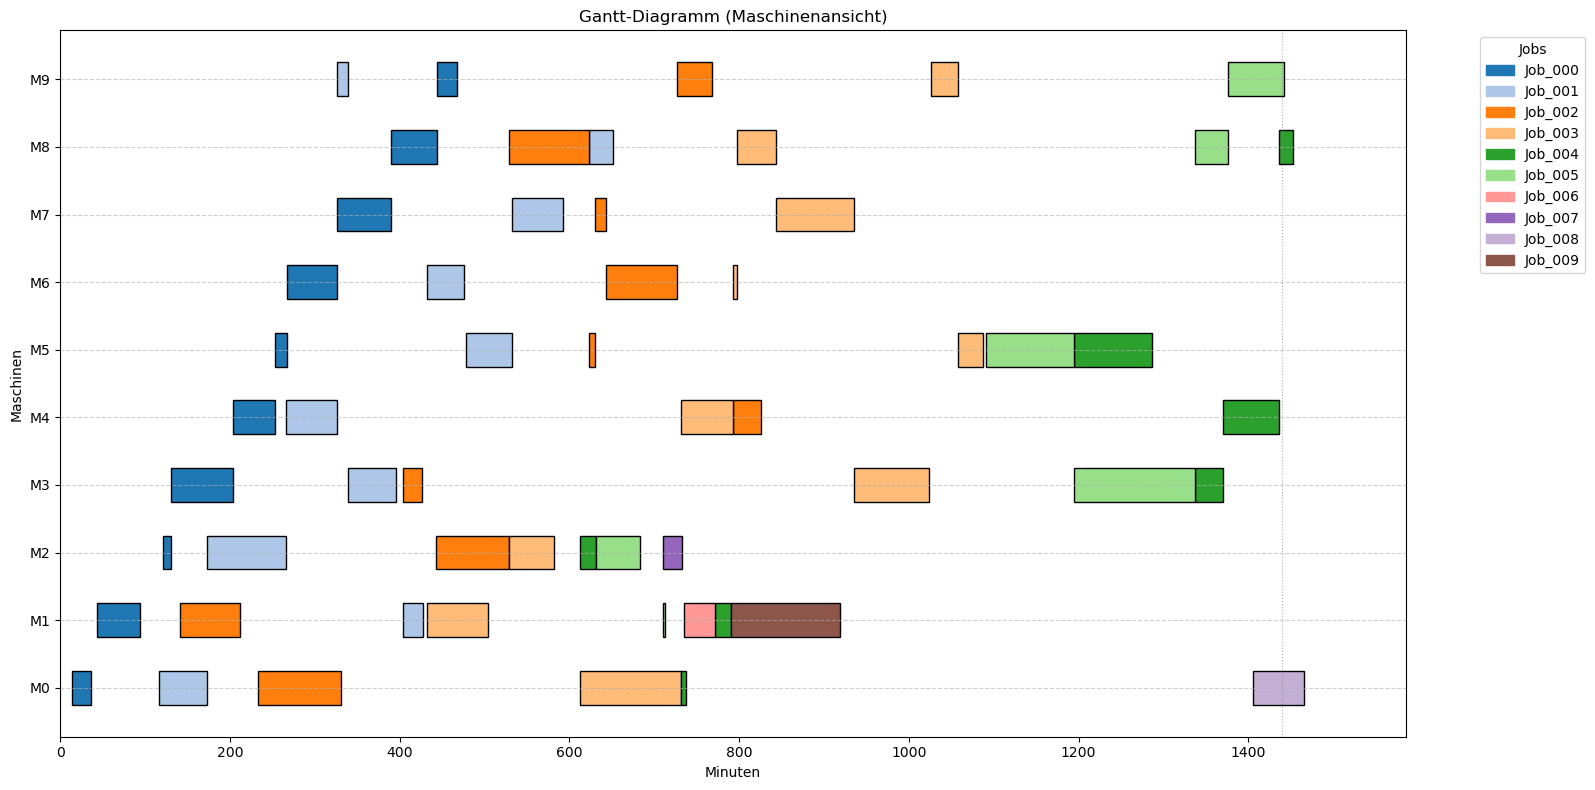

In [18]:
show.plot_gantt_machines(df_execution, duration_column = "Simulated Processing Time")

### 3) Verbliebe Jobs nach Tag 0

In [19]:
df_plan = df_plan0

df_rest = df_plan.merge(df_execution[["Job", "Machine"]], on=["Job", "Machine"], how="left", indicator=True)
df_rest = df_rest[df_rest["_merge"] == "left_only"].drop(columns=["_merge"])
df_rest = df_rest.sort_values(by=["Arrival", "Start"]).reset_index(drop=True)
df_rest

,Job,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,Job_004,236.45,2572.747002,M7,1354.52,49,1403.52,0.000000
1,Job_004,236.45,2572.747002,M9,1403.52,72,1475.52,0.000000
2,Job_004,236.45,2572.747002,M6,1475.52,53,1528.52,0.000000
3,Job_005,316.00,3264.608939,M0,1358.46,47,1405.46,0.000000
4,Job_005,316.00,3264.608939,M6,1405.46,65,1470.46,0.000000
...,...,...,...,...,...,...,...,...
628,Job_068,4210.59,7587.222818,M5,8562.02,10,8572.02,1173.857182
629,Job_068,4210.59,7587.222818,M7,8582.08,12,8594.08,1173.857182
630,Job_068,4210.59,7587.222818,M6,8594.08,89,8683.08,1173.857182
631,Job_068,4210.59,7587.222818,M9,8683.08,45,8728.08,1173.857182


In [20]:
jssp_data_rest = convert.get_jssp_from_schedule(df_rest)
show.print_jobs(jssp_data_rest)

Job_004:  [[7, 49], [9, 72], [6, 53]]
Job_005:  [[0, 47], [6, 65], [4, 6], [7, 25]]
Job_006:  [[0, 37], [3, 61], [2, 13], [6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
Job_007:  [[0, 86], [1, 46], [5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
Job_008:  [[1, 69], [3, 76], [5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
Job_009:  [[0, 13], [2, 61], [6, 7], [8, 64], [9, 76], [5, 47], [3, 52], [4, 90], [7, 45]]
Job_010:  [[0, 76], [1, 69], [3, 76], [5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
Job_011:  [[1, 46], [0, 37], [3, 61], [2, 13], [6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
Job_012:  [[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
Job_013:  [[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
Job_014:  [[1, 81], [2, 95], [0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
Job_015:  [[0, 43], [2, 90], [4, 75], [9, 11],

In [21]:
allowed = df_rest["Job"].unique() 
df_time_rest = df_times[df_times["Job"].isin(allowed)].copy()
df_time_rest

,Job,Arrival,Deadline
4,Job_004,236.45,2572.747002
5,Job_005,316.00,3264.608939
6,Job_006,389.61,2862.636852
7,Job_007,409.92,3614.154311
8,Job_008,427.52,3976.551324
...,...,...,...
64,Job_064,3749.15,6085.447002
65,Job_065,3907.00,7111.234311
66,Job_066,4061.64,6409.826555
67,Job_067,4110.12,7141.955805


## Day 1

In [22]:
jssp_data1, df_times1 = rp.update_new_day(jssp_data_rest, df_time_rest, instance, u_b_mmax= 0.75, generate_deadlines = True, deadlines_buffer_factor= 1.9)
show.print_jobs(jssp_data1)
df_times1

Job_004:  [[7, 49], [9, 72], [6, 53]]
Job_005:  [[0, 47], [6, 65], [4, 6], [7, 25]]
Job_006:  [[0, 37], [3, 61], [2, 13], [6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
Job_007:  [[0, 86], [1, 46], [5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
Job_008:  [[1, 69], [3, 76], [5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
Job_009:  [[0, 13], [2, 61], [6, 7], [8, 64], [9, 76], [5, 47], [3, 52], [4, 90], [7, 45]]
Job_010:  [[0, 76], [1, 69], [3, 76], [5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
Job_011:  [[1, 46], [0, 37], [3, 61], [2, 13], [6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
Job_012:  [[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
Job_013:  [[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
Job_014:  [[1, 81], [2, 95], [0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
Job_015:  [[0, 43], [2, 90], [4, 75], [9, 11],

,Job,Arrival,Deadline
0,Job_004,236.45,2572.747002
1,Job_005,316.00,3264.608939
2,Job_006,389.61,2862.636852
3,Job_007,409.92,3614.154311
4,Job_008,427.52,3976.551324
...,...,...,...
83,Job_087,5189.15,7525.447002
84,Job_088,5347.00,8551.234311
85,Job_089,5501.64,7849.826555
86,Job_090,5550.12,8581.955805


### 1) Rescheduling

In [23]:
# Bereits ausgeführte Operationen, die noch in die Zukunft ragen
df_execution_important = df_execution[df_execution["End"] >= 1440]

# Neuer Reschedule-Lauf mit Tardiness-Ziel
df_plan1, total_T = solve_jssp_sum_tardiness_with_fixed_operations(
    job_dict=jssp_data1,
    df_arrivals_deadlines=df_times1,   # enthält Arrival + Deadline
    df_executed=df_execution_important,
    solver_time_limit=60 * minutes,
    epsilon=0.6,
    arrival_column="Arrival",
    deadline_column="Deadline",
    reschedule_start=1440
)

🔁 Starte Rescheduling (Tardiness) ab t = 1440
🔹 88 Jobs erkannt
Running HiGHS 1.10.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
Set option time_limit to 3000
Set option solution_file to "/var/folders/88/5n59t5yx3095jhz9lldbm0kr0000gn/T/2b51d614f16d445b8b65a567834901b5-pulp.sol"
Set option log_file to "/var/folders/88/5n59t5yx3095jhz9lldbm0kr0000gn/T/2b51d614f16d445b8b65a567834901b5-pulp.HiGHS_log"
Set option write_solution_to_file to true
Number of BV entries in BOUNDS section is 37073
MIP  2b51d614f16d445b8b65a567834901b5-pulp has 75185 rows; 38112 cols; 223910 nonzeros; 37073 integer variables (37073 binary)
Coefficient ranges:
  Matrix [1e+00, 1e+05]
  Cost   [1e+00, 1e+00]
  Bound  [1e+00, 1e+00]
  RHS    [2e+00, 1e+05]
Presolving model
74947 rows, 37952 cols, 223440 nonzeros  0s
43233 rows, 37952 cols, 128462 nonzeros  0s
43161 rows, 37916 cols, 128318 nonzeros  0s

Solving MIP model with:
   43161 rows
   37916 cols (36965 binary, 0 integer, 0 implied int.,

In [24]:
print(f"Final End:{max(df_plan1.End)}")
df_plan1

Final End:18114.5


,Job,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,Job_091,5650.59,9027.222818,M1,17546.50,91,17637.50,9087.277182
1,Job_091,5650.59,9027.222818,M0,17637.50,85,17722.50,9087.277182
2,Job_091,5650.59,9027.222818,M3,17722.50,39,17761.50,9087.277182
3,Job_091,5650.59,9027.222818,M2,17761.50,74,17835.50,9087.277182
4,Job_091,5650.59,9027.222818,M8,17835.50,90,17925.50,9087.277182
...,...,...,...,...,...,...,...,...
858,Job_005,316.00,3264.608939,M4,1724.71,6,1730.71,0.000000
859,Job_005,316.00,3264.608939,M7,1730.71,25,1755.71,0.000000
860,Job_004,236.45,2572.747002,M7,1452.51,49,1501.51,0.000000
861,Job_004,236.45,2572.747002,M9,1501.51,72,1573.51,0.000000


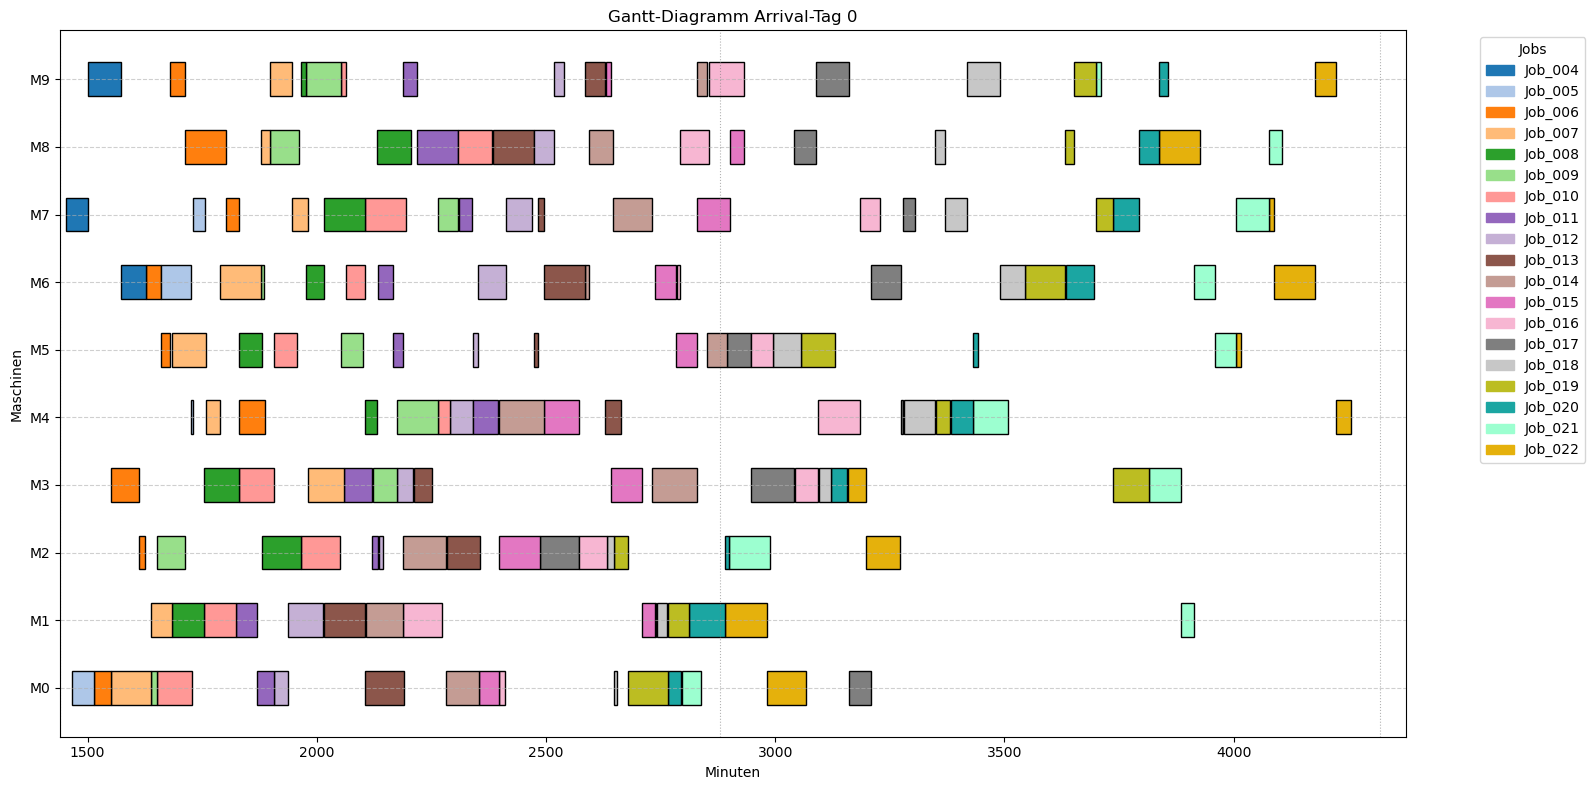

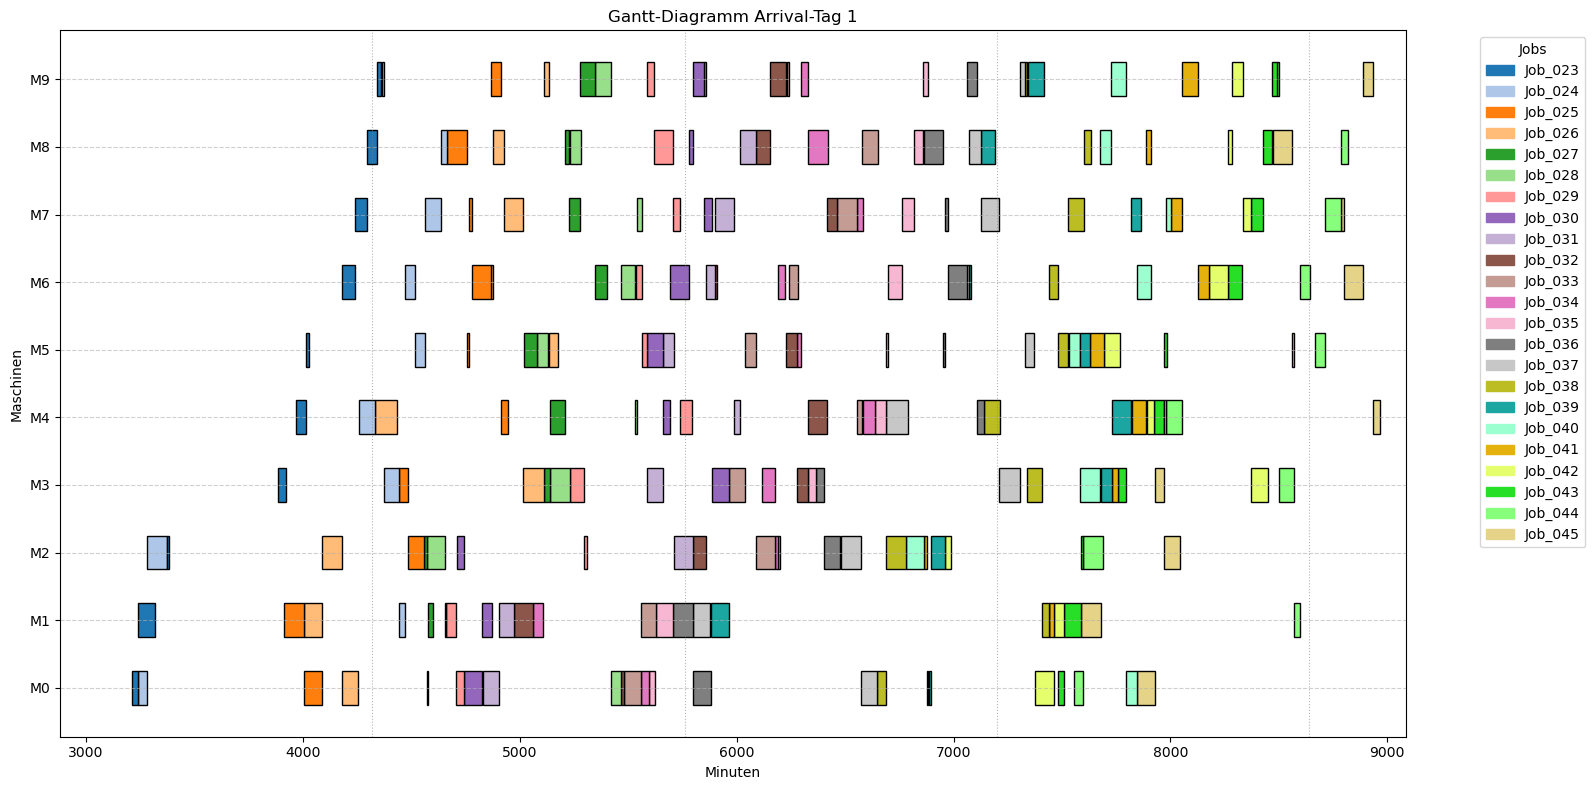

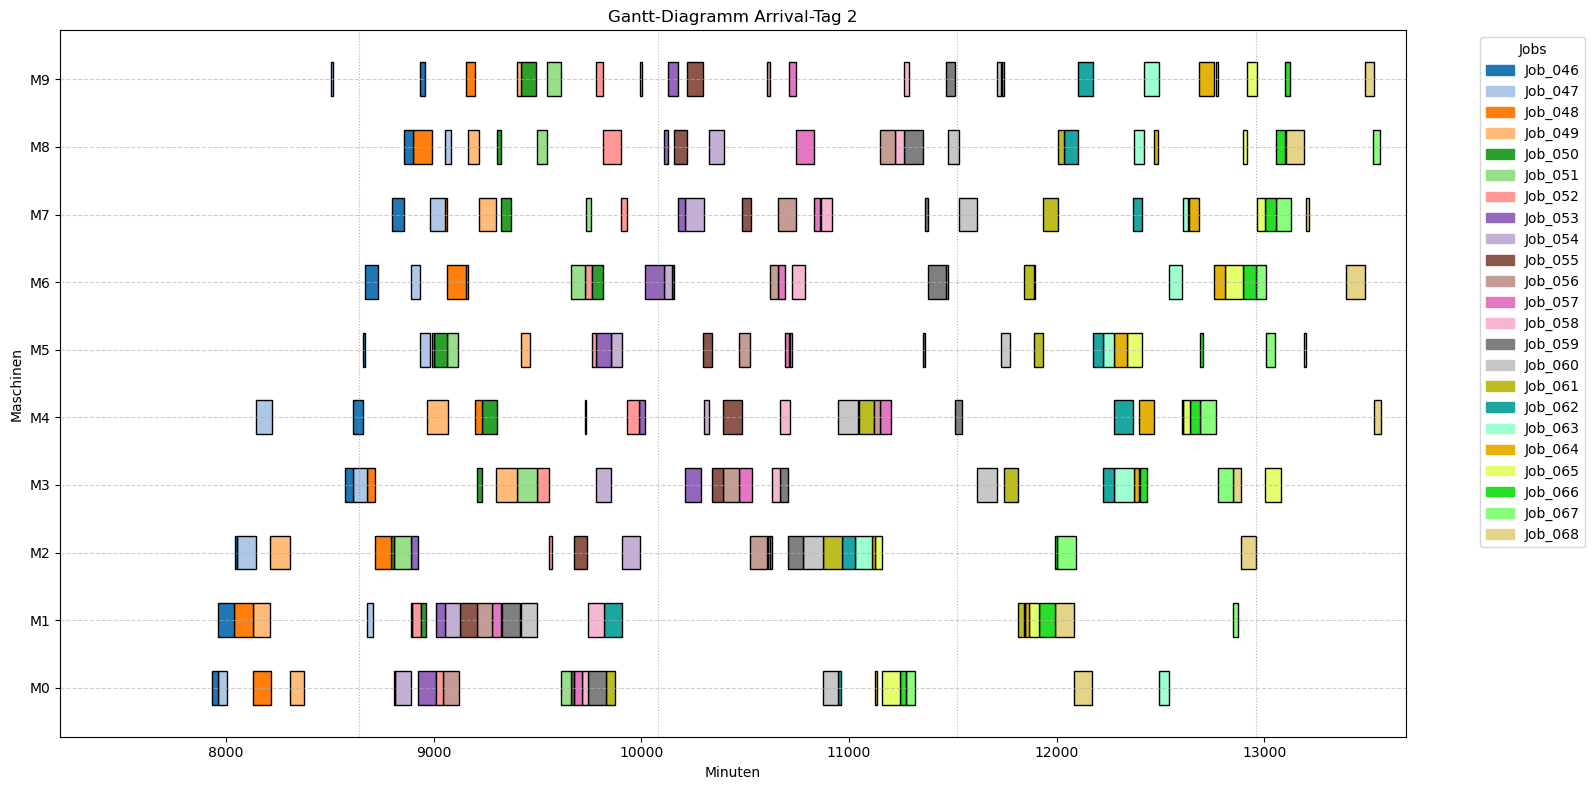

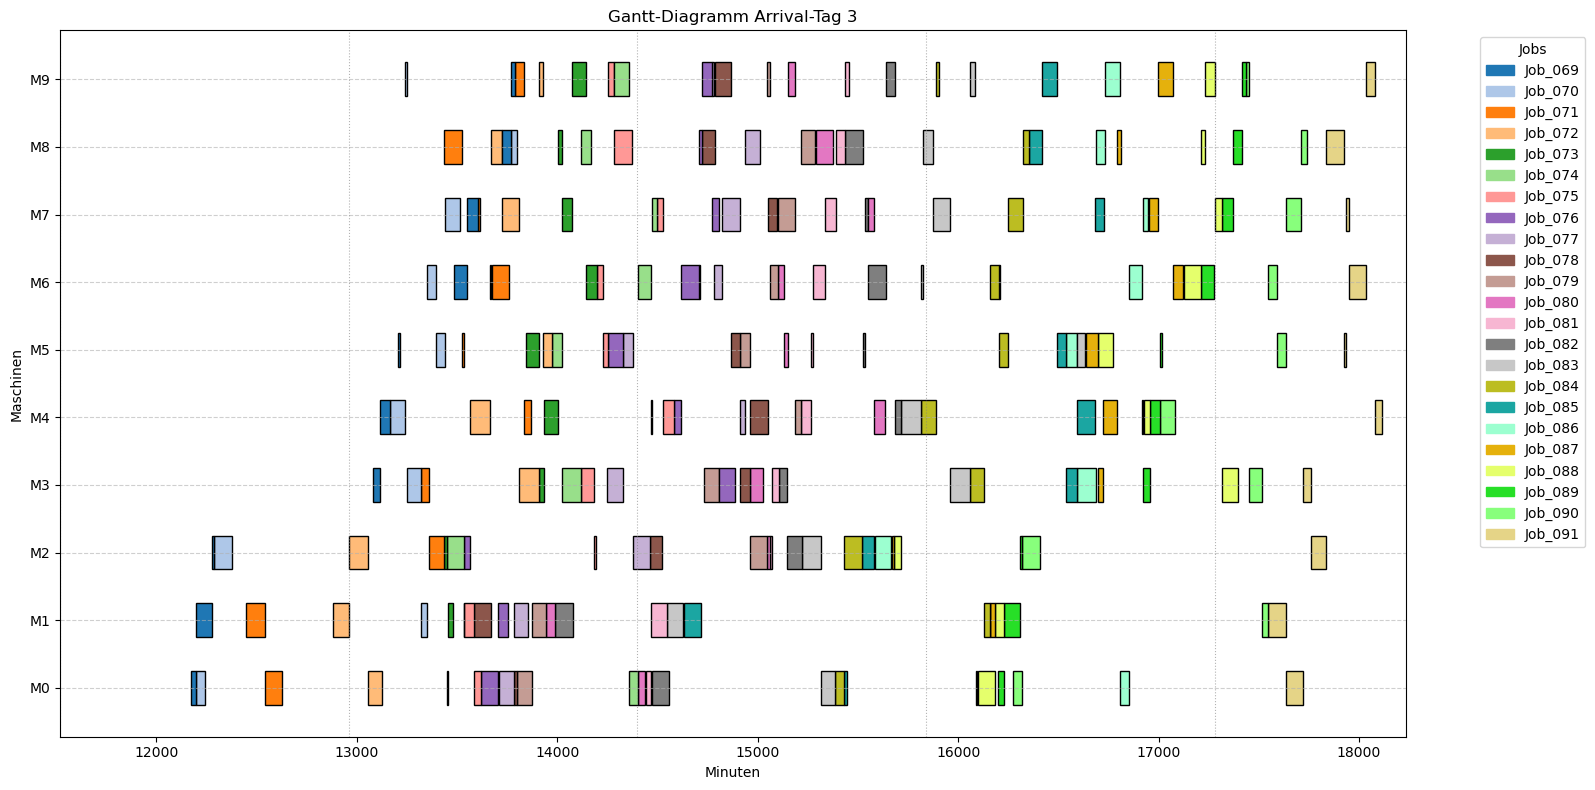

In [25]:
df = df_plan1

block = 1440                                        
for idx, part_df in df.groupby(df['Arrival'] // block, sort=True):
    show.plot_gantt_machines(part_df, f"Gantt-Diagramm Arrival-Tag {int(idx)}")

### 2) Simulation für Tag 1

In [26]:
day_start = 1440
day_end = day_start + 1440

filt = (df_plan1["Start"] >=  day_start) & (df_plan1["Start"] < day_end)
df_schedule_1 = df_plan1[filt]
df_schedule_1

,Job,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
700,Job_021,1230.12,4261.955805,M0,2795.50,43,2838.50,0.000000
710,Job_020,1181.64,3529.826555,M0,2765.90,29,2794.90,327.673445
711,Job_020,1181.64,3529.826555,M1,2811.90,78,2889.90,327.673445
720,Job_019,1027.00,4231.234311,M2,2648.30,31,2679.30,0.000000
721,Job_019,1027.00,4231.234311,M0,2679.30,86,2765.30,0.000000
...,...,...,...,...,...,...,...,...
858,Job_005,316.00,3264.608939,M4,1724.71,6,1730.71,0.000000
859,Job_005,316.00,3264.608939,M7,1730.71,25,1755.71,0.000000
860,Job_004,236.45,2572.747002,M7,1452.51,49,1501.51,0.000000
861,Job_004,236.45,2572.747002,M9,1501.51,72,1573.51,0.000000


In [27]:
simulation = ProductionDaySimulation(df_schedule_1, vc=0.25)
df_execution, df_undone = simulation.run(start_time = day_start, end_time=day_end)

[24:12:30] Job_004 started on M7
[24:26:30] Job_005 started on M0
[24:50:02] Job_004 finished on M7 (after 37 minutes 32 seconds)
[25:01:30] Job_004 started on M9
[25:28:50] Job_005 finished on M0 (after 62 minutes 21 seconds)
[25:28:50] Job_006 started on M0
[25:57:16] Job_006 finished on M0 (after 28 minutes 25 seconds)
[25:57:16] Job_007 started on M0
[25:57:16] Job_006 started on M3
[26:09:35] Job_004 finished on M9 (after 68 minutes 05 seconds)
[26:13:30] Job_004 started on M6
[26:44:03] Job_004 finished on M6 (after 30 minutes 33 seconds)
[27:11:17] Job_006 finished on M3 (after 74 minutes 01 second)
[27:11:17] Job_006 started on M2
[27:12:57] Job_007 finished on M0 (after 75 minutes 41 seconds)
[27:17:42] Job_007 started on M1
[27:18:17] Job_009 started on M0
[27:22:01] Job_006 finished on M2 (after 10 minutes 44 seconds)
[27:22:01] Job_006 started on M6
[27:26:24] Job_009 finished on M0 (after 08 minutes 07 seconds)
[27:31:17] Job_009 started on M2
[27:31:54] Job_010 started on

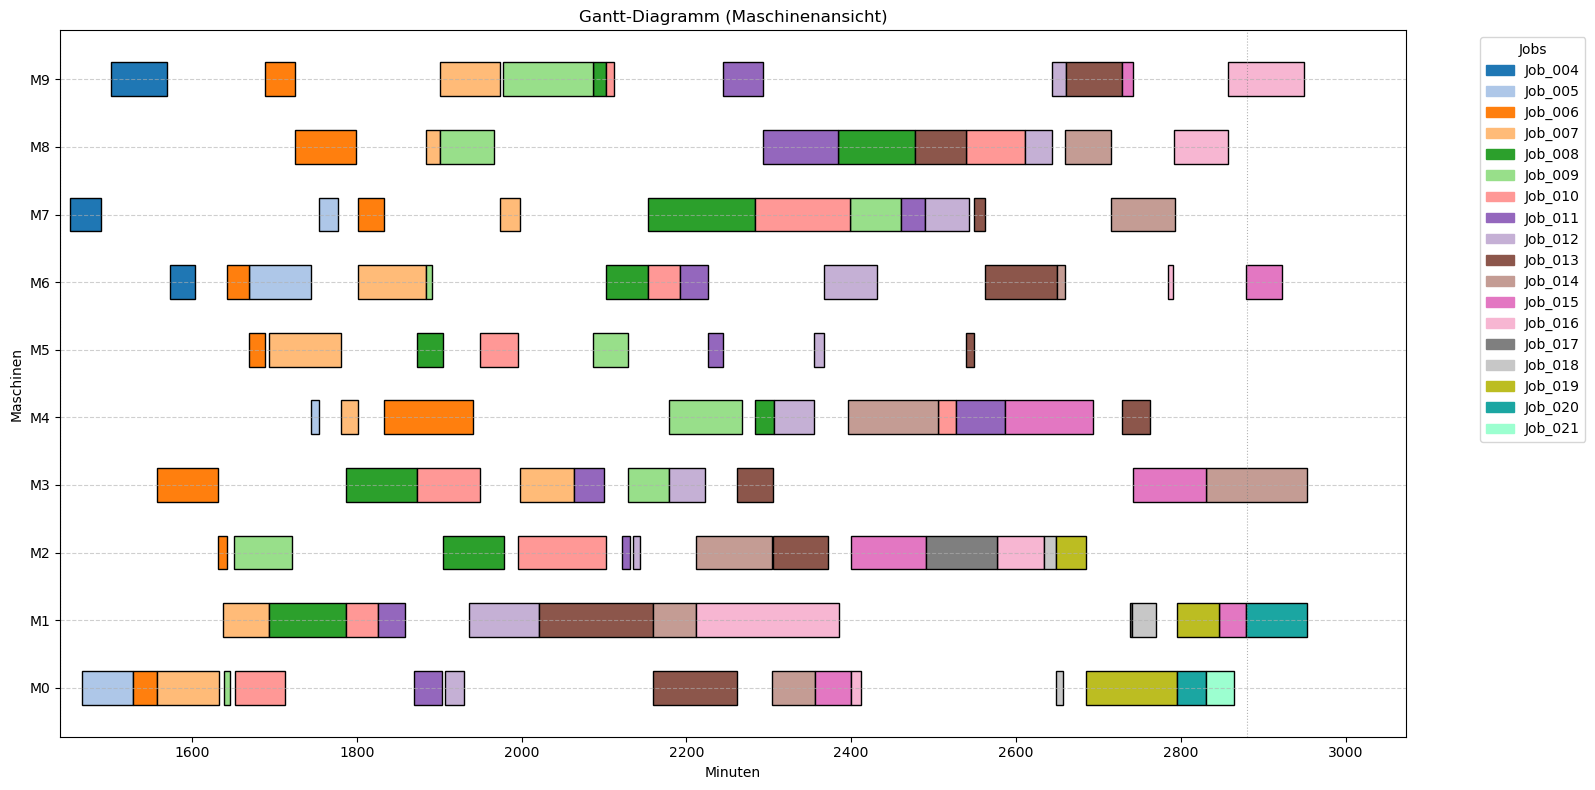

In [28]:
show.plot_gantt_machines(df_execution, duration_column = "Simulated Processing Time")

### 3) Verbleibene Jobs nach Tag 1

In [29]:
df_plan = df_plan1

df_rest = df_plan.merge(df_execution[["Job", "Machine"]], on=["Job", "Machine"], how="left", indicator=True)
df_rest = df_rest[df_rest["_merge"] == "left_only"].drop(columns=["_merge"])
df_rest = df_rest.sort_values(by=["Arrival", "Start"]).reset_index(drop=True)
df_rest

,Job,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,Job_014,687.70,4581.528337,M9,2829.1,22,2851.1,0.000000
1,Job_014,687.70,4581.528337,M5,2851.1,43,2894.1,0.000000
2,Job_015,710.50,3742.335805,M5,2784.1,46,2830.1,0.000000
3,Job_015,710.50,3742.335805,M7,2830.1,72,2902.1,0.000000
4,Job_015,710.50,3742.335805,M8,2902.1,30,2932.1,0.000000
...,...,...,...,...,...,...,...,...
743,Job_091,5650.59,9027.222818,M5,17925.5,10,17935.5,9087.277182
744,Job_091,5650.59,9027.222818,M7,17935.5,12,17947.5,9087.277182
745,Job_091,5650.59,9027.222818,M6,17947.5,89,18036.5,9087.277182
746,Job_091,5650.59,9027.222818,M9,18036.5,45,18081.5,9087.277182


In [30]:
jssp_data_rest = convert.get_jssp_from_schedule(df_rest)
show.print_jobs(jssp_data_rest)

Job_014:  [[9, 22], [5, 43]]
Job_015:  [[5, 46], [7, 72], [8, 30]]
Job_016:  [[5, 47], [3, 52], [4, 90], [7, 45]]
Job_017:  [[5, 52], [3, 95], [8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
Job_018:  [[5, 61], [3, 26], [4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
Job_019:  [[5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
Job_020:  [[2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
Job_021:  [[2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
Job_022:  [[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
Job_023:  [[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
Job_024:  [[0, 43], [2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
Job_025:  [[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
Job_026:  [[1, 81], [2, 95], [0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98

In [31]:
df_times = df_times1

allowed = df_rest["Job"].unique() 
df_time_rest = df_times[df_times["Job"].isin(allowed)].copy()
df_time_rest

,Job,Arrival,Deadline
10,Job_014,687.70,4581.528337
11,Job_015,710.50,3742.335805
12,Job_016,779.36,3989.539087
13,Job_017,798.47,3747.078939
14,Job_018,869.15,3205.447002
...,...,...,...
83,Job_087,5189.15,7525.447002
84,Job_088,5347.00,8551.234311
85,Job_089,5501.64,7849.826555
86,Job_090,5550.12,8581.955805


## Day 2

In [32]:
jssp_data2, df_times2 = rp.update_new_day(jssp_data_rest, df_time_rest, instance, u_b_mmax= 0.75, generate_deadlines = True, deadlines_buffer_factor= 1.9)
show.print_jobs(jssp_data2)
df_times2

Job_014:  [[9, 22], [5, 43]]
Job_015:  [[5, 46], [7, 72], [8, 30]]
Job_016:  [[5, 47], [3, 52], [4, 90], [7, 45]]
Job_017:  [[5, 52], [3, 95], [8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
Job_018:  [[5, 61], [3, 26], [4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
Job_019:  [[5, 74], [4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
Job_020:  [[2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
Job_021:  [[2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
Job_022:  [[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
Job_023:  [[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
Job_024:  [[0, 43], [2, 90], [4, 75], [9, 11], [3, 69], [1, 28], [6, 46], [5, 46], [7, 72], [8, 30]]
Job_025:  [[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
Job_026:  [[1, 81], [2, 95], [0, 71], [4, 99], [6, 9], [8, 52], [7, 85], [3, 98

,Job,Arrival,Deadline
0,Job_014,687.70,4581.528337
1,Job_015,710.50,3742.335805
2,Job_016,779.36,3989.539087
3,Job_017,798.47,3747.078939
4,Job_018,869.15,3205.447002
...,...,...,...
96,Job_110,6629.15,8965.447002
97,Job_111,6787.00,9991.234311
98,Job_112,6941.64,9289.826555
99,Job_113,6990.12,10021.955805


### 1) Rescheduling

In [33]:
# Reduktion der bereits ausgeführten Operationen auf die relevanten für die nächsten Tage
df_execution_important = df_execution[df_execution["End"] >= 2880]
df_execution_important

,Job,Arrival,Machine,Start,Simulated Processing Time,Flow time,End
90,Job_014,687.70,M3,2830.75,122.47,2265.52,2953.22
97,Job_015,710.50,M6,2878.64,43.63,2211.77,2922.27
103,Job_016,779.36,M9,2856.97,92.90,2170.51,2949.87
113,Job_020,1181.64,M1,2878.64,74.79,1771.79,2953.43


In [34]:
df_plan2, total_T = solve_jssp_sum_tardiness_with_fixed_operations(
    job_dict=jssp_data2,
    df_arrivals_deadlines=df_times2,
    df_executed=df_execution_important,
    solver_time_limit=60 * minutes,
    epsilon=0.6,
    arrival_column="Arrival",
    deadline_column="Deadline",
    reschedule_start=2880
)

🔁 Starte Rescheduling (Tardiness) ab t = 2880
🔹 101 Jobs erkannt
Running HiGHS 1.10.0 (git hash: n/a): Copyright (c) 2025 HiGHS under MIT licence terms
Set option time_limit to 3000
Set option solution_file to "/var/folders/88/5n59t5yx3095jhz9lldbm0kr0000gn/T/99946e3df24c41de935d38f46a79a993-pulp.sol"
Set option log_file to "/var/folders/88/5n59t5yx3095jhz9lldbm0kr0000gn/T/99946e3df24c41de935d38f46a79a993-pulp.HiGHS_log"
Set option write_solution_to_file to true
Number of BV entries in BOUNDS section is 47754
MIP  99946e3df24c41de935d38f46a79a993-pulp has 96688 rows; 48934 cols; 288003 nonzeros; 47754 integer variables (47754 binary)
Coefficient ranges:
  Matrix [1e+00, 1e+05]
  Cost   [1e+00, 1e+00]
  Bound  [1e+00, 1e+00]
  RHS    [2e+00, 1e+05]
Presolving model
96432 rows, 48769 cols, 287518 nonzeros  0s
54861 rows, 48769 cols, 162953 nonzeros  0s
54659 rows, 48668 cols, 162549 nonzeros  0s

Solving MIP model with:
   54659 rows
   48668 cols (47589 binary, 0 integer, 0 implied int.

In [35]:
print(f"Final End:{max(df_plan2.End)}")
df_plan2

Final End:21368.0


,Job,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,Job_114,7090.59,10467.222818,M1,19803.80,91,19894.80,10900.777182
1,Job_114,7090.59,10467.222818,M0,20349.60,85,20434.60,10900.777182
2,Job_114,7090.59,10467.222818,M3,20867.00,39,20906.00,10900.777182
3,Job_114,7090.59,10467.222818,M2,20906.00,74,20980.00,10900.777182
4,Job_114,7090.59,10467.222818,M8,21089.00,90,21179.00,10900.777182
...,...,...,...,...,...,...,...,...
973,Job_015,710.50,3742.335805,M5,2941.60,46,2987.60,0.000000
974,Job_015,710.50,3742.335805,M7,2987.60,72,3059.60,0.000000
975,Job_015,710.50,3742.335805,M8,3070.42,30,3100.42,0.000000
976,Job_014,687.70,4581.528337,M9,2953.22,22,2975.22,0.000000


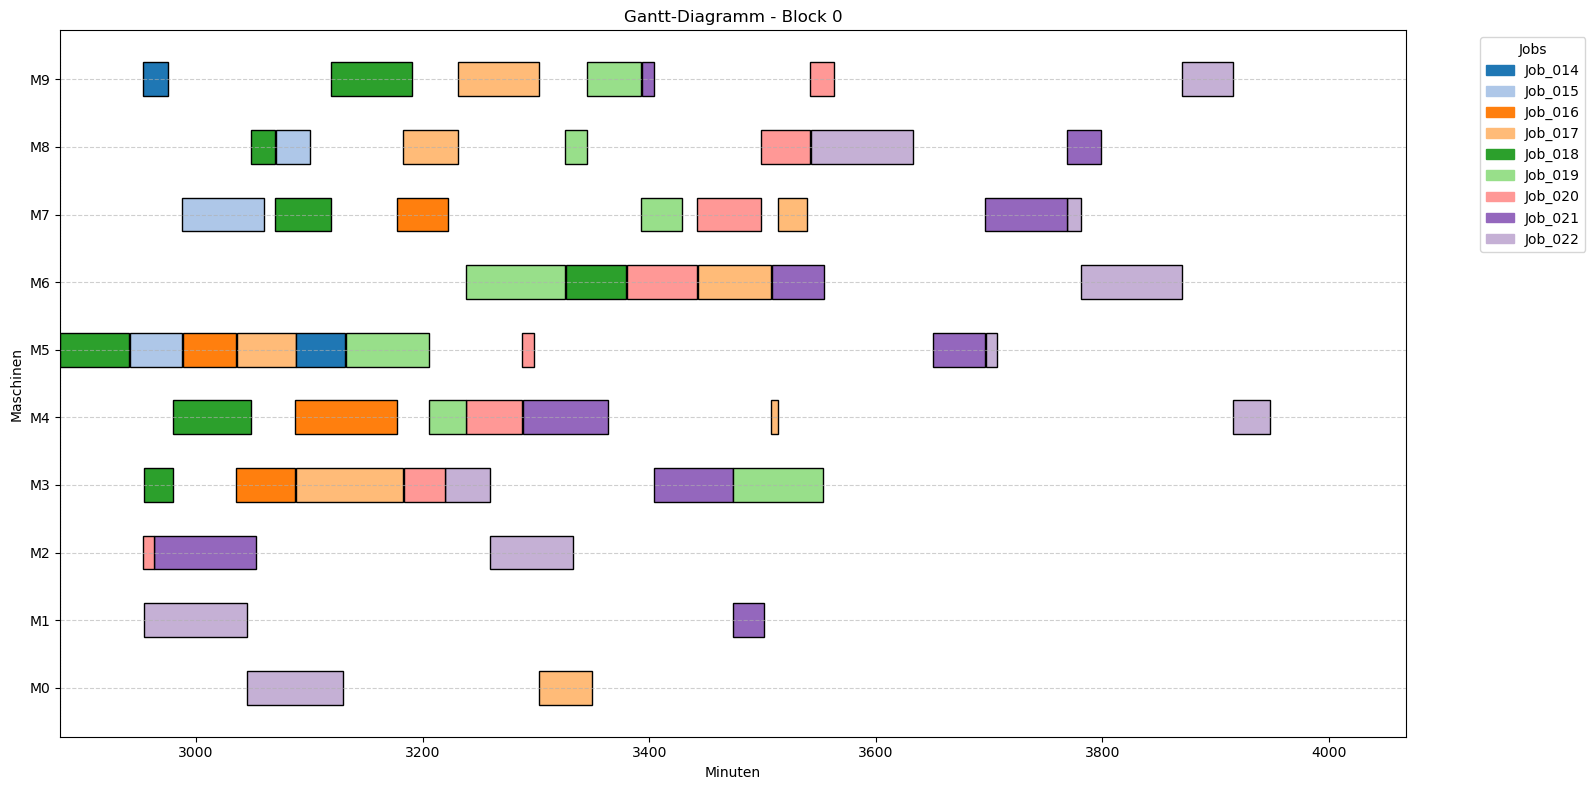

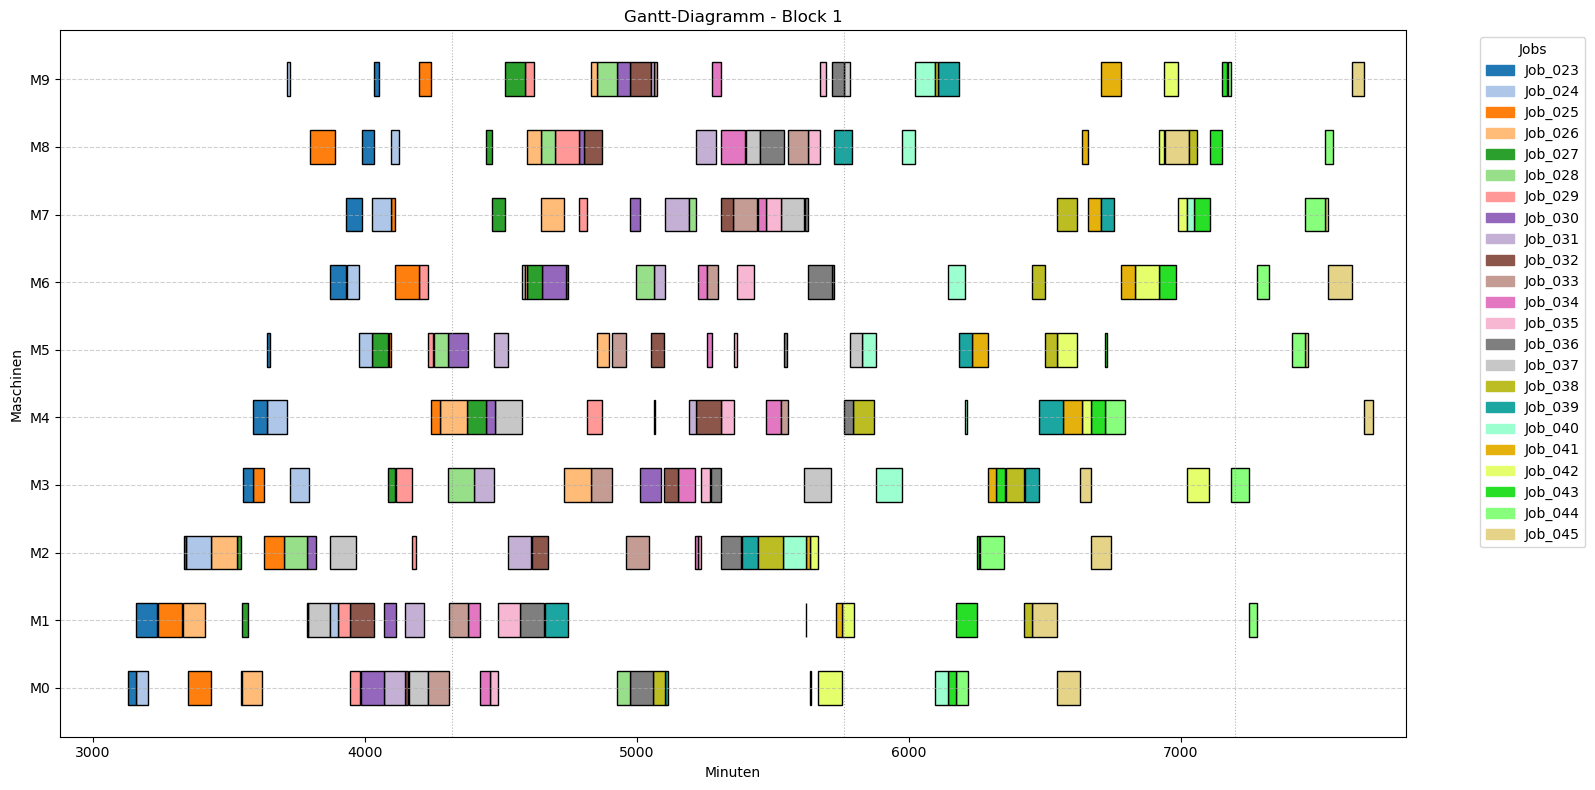

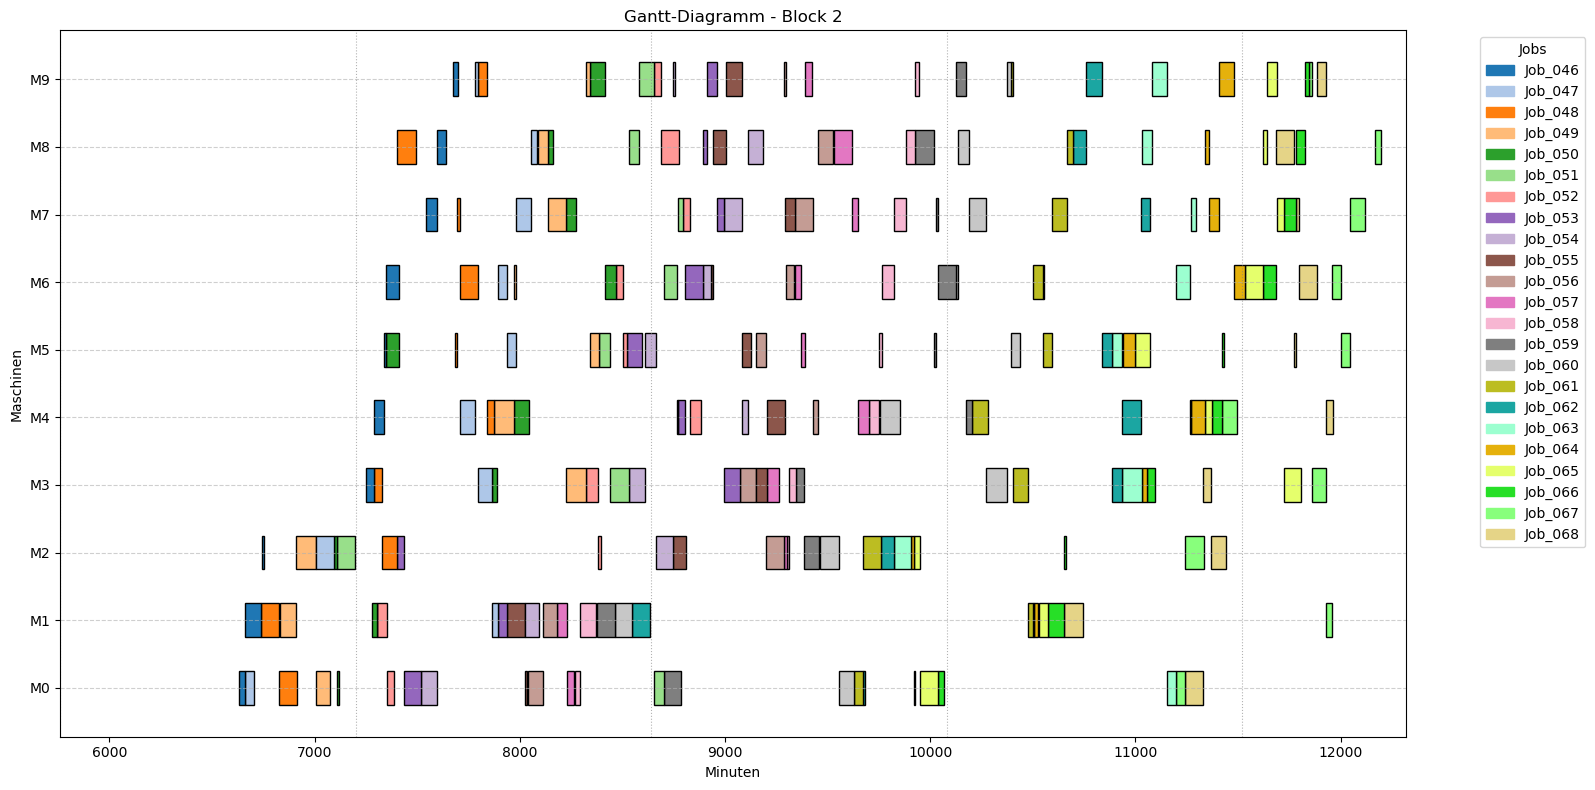

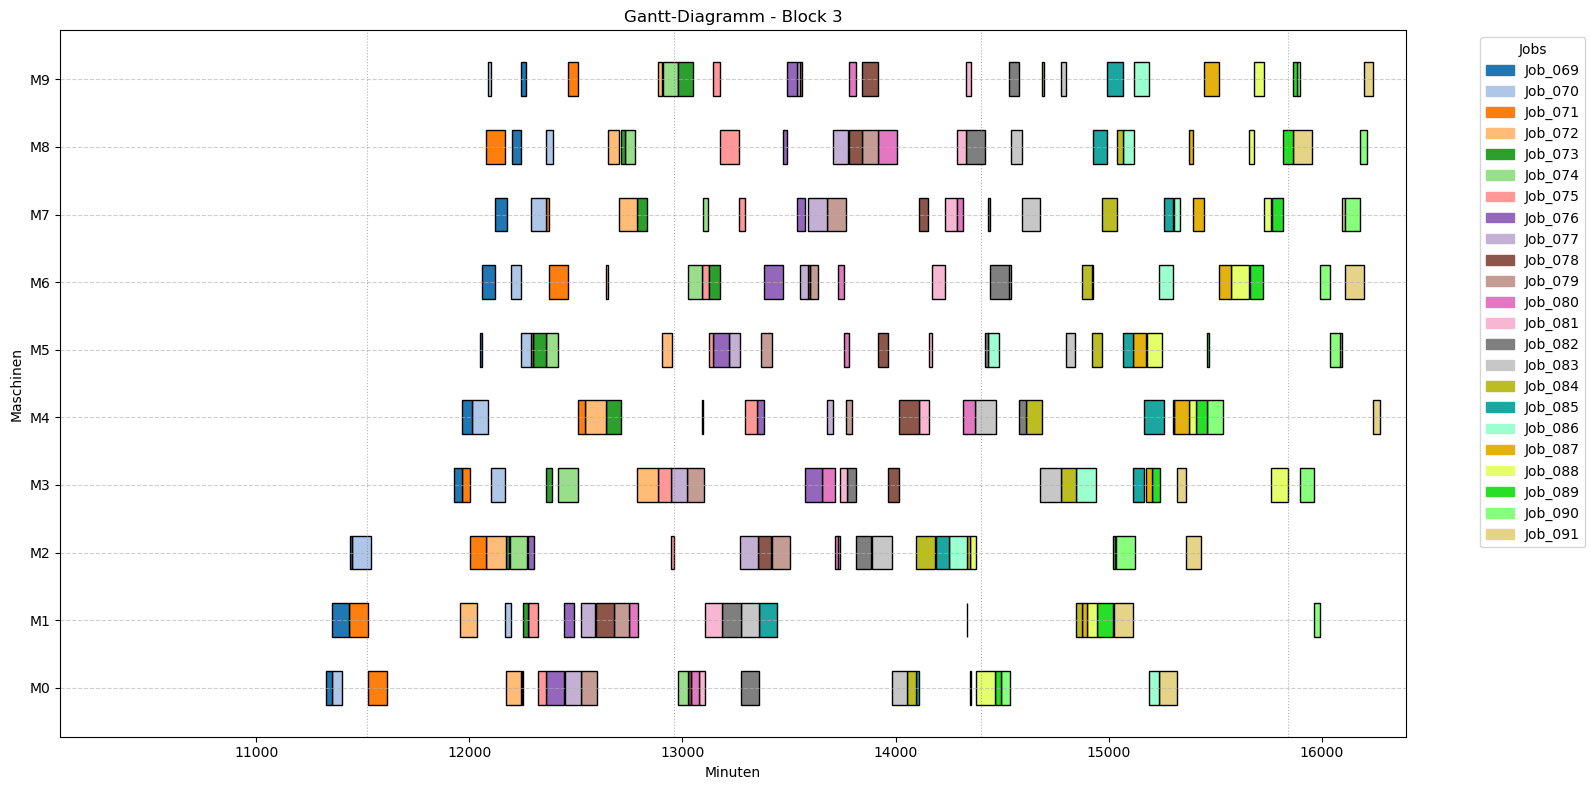

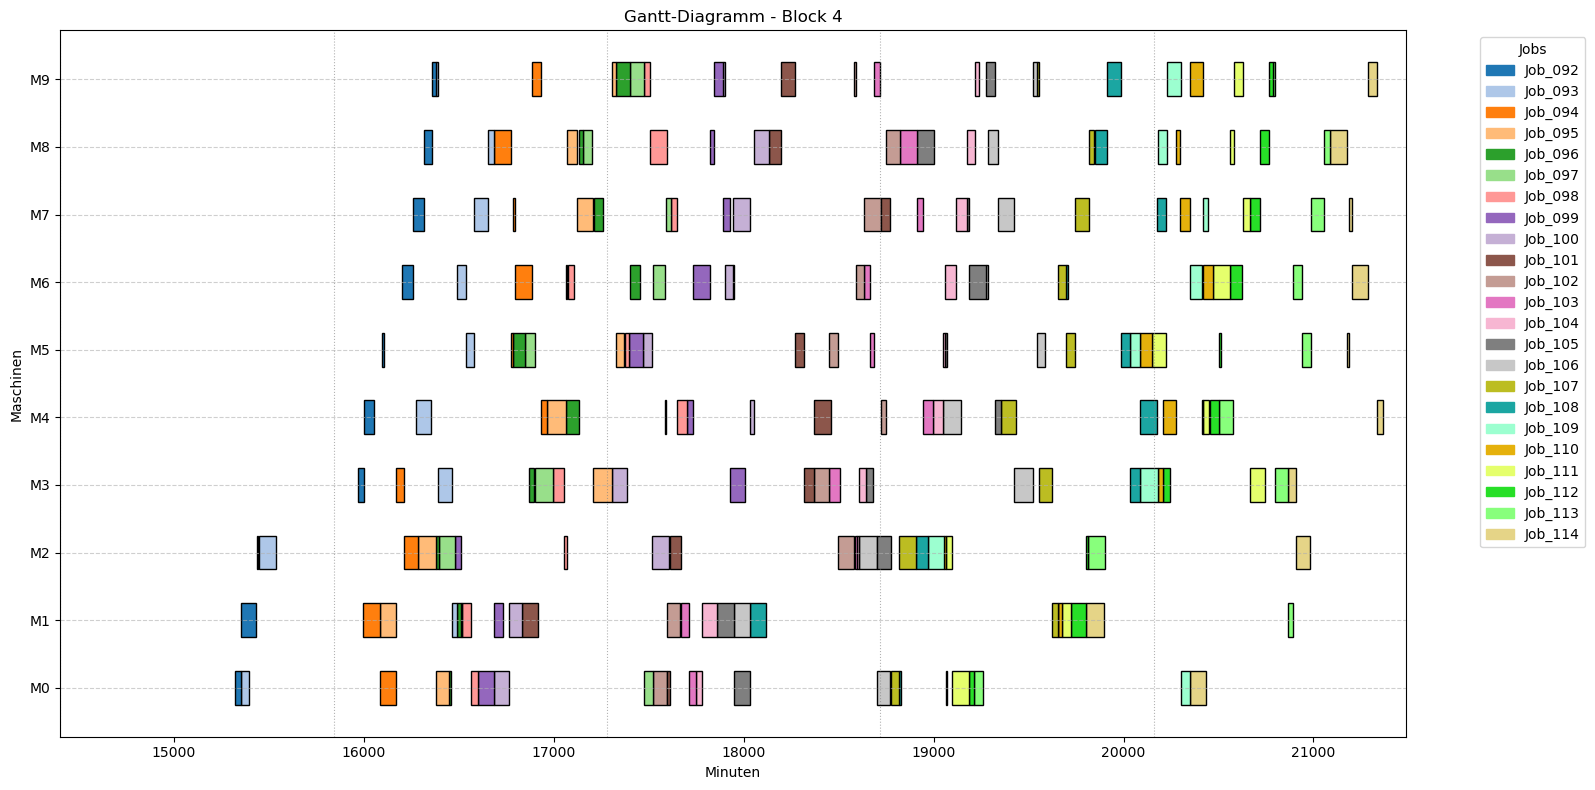

In [36]:
df = df_plan2

block = 1440                                        
for idx, part_df in df.groupby(df['Arrival'] // block, sort=True):
    show.plot_gantt_machines(part_df, f"Gantt-Diagramm - Block {int(idx)}")

### 2) Simulation für Tag 2

In [37]:
day_start = 2880
day_end = day_start + 1440

filt = (df_plan2["Start"] >=  day_start) & (df_plan2["Start"] < day_end)
df_schedule_2 = df_plan2[filt]
df_schedule_2

,Job,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
770,Job_037,2127.70,6021.528337,M1,3790.60,81,3871.60,0.000000
771,Job_037,2127.70,6021.528337,M2,3871.60,95,3966.60,0.000000
772,Job_037,2127.70,6021.528337,M0,4161.20,71,4232.20,0.000000
810,Job_033,2022.94,5571.971324,M0,4232.80,76,4308.80,57.628676
811,Job_033,2022.94,5571.971324,M1,4308.80,69,4377.80,57.628676
...,...,...,...,...,...,...,...,...
973,Job_015,710.50,3742.335805,M5,2941.60,46,2987.60,0.000000
974,Job_015,710.50,3742.335805,M7,2987.60,72,3059.60,0.000000
975,Job_015,710.50,3742.335805,M8,3070.42,30,3100.42,0.000000
976,Job_014,687.70,4581.528337,M9,2953.22,22,2975.22,0.000000


In [38]:
simulation = ProductionDaySimulation(df_schedule_2, vc=0.25)
df_execution, df_undone = simulation.run(start_time = day_start, end_time=day_end)

[48:00:00] Job_018 started on M5
[49:13:13] Job_014 started on M9
[49:13:25] Job_020 started on M2
[49:14:01] Job_022 started on M1
[49:20:34] Job_020 finished on M2 (after 07 minutes 09 seconds)
[49:21:56] Job_018 finished on M5 (after 81 minutes 57 seconds)
[49:21:56] Job_015 started on M5
[49:21:56] Job_018 started on M3
[49:23:01] Job_021 started on M2
[49:30:04] Job_014 finished on M9 (after 16 minutes 51 seconds)
[49:43:25] Job_018 finished on M3 (after 21 minutes 28 seconds)
[49:43:25] Job_018 started on M4
[50:22:58] Job_015 finished on M5 (after 61 minutes 02 seconds)
[50:22:58] Job_016 started on M5
[50:22:58] Job_015 started on M7
[50:26:19] Job_022 finished on M1 (after 72 minutes 18 seconds)
[50:26:40] Job_021 finished on M2 (after 63 minutes 39 seconds)
[50:41:16] Job_018 finished on M4 (after 57 minutes 51 seconds)
[50:45:01] Job_022 started on M0
[50:48:49] Job_018 started on M8
[50:59:04] Job_016 finished on M5 (after 36 minutes 06 seconds)
[50:59:04] Job_017 started o

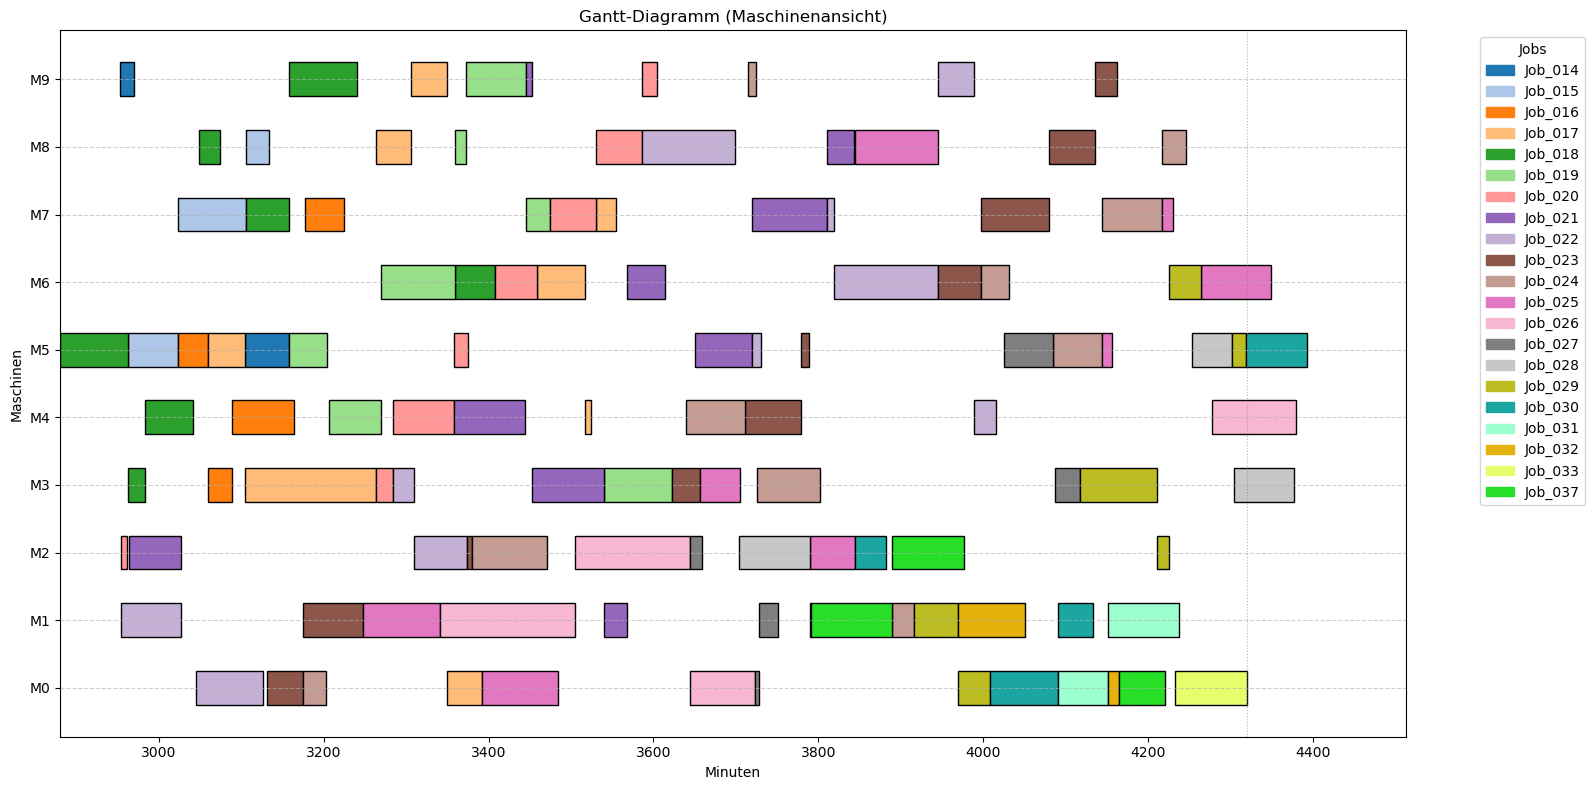

In [39]:
show.plot_gantt_machines(df_execution, duration_column = "Simulated Processing Time")

### 3) Verbleibene Jobs nach Tag 2

In [40]:
df_plan = df_plan2

df_rest = df_plan.merge(df_execution[["Job", "Machine"]], on=["Job", "Machine"], how="left", indicator=True)
df_rest = df_rest[df_rest["_merge"] == "left_only"].drop(columns=["_merge"])
df_rest = df_rest.sort_values(by=["Arrival", "Start"]).reset_index(drop=True)
df_rest

,Job,Arrival,Deadline,Machine,Start,Processing Time,End,Tardiness
0,Job_025,1581.78,4958.412818,M9,4198.8,45,4243.8,0.000000
1,Job_025,1581.78,4958.412818,M4,4243.8,33,4276.8,0.000000
2,Job_026,1632.34,5526.168337,M6,4587.8,9,4596.8,0.000000
3,Job_026,1632.34,5526.168337,M8,4596.8,52,4648.8,0.000000
4,Job_026,1632.34,5526.168337,M7,4648.8,85,4733.8,0.000000
...,...,...,...,...,...,...,...,...
856,Job_114,7090.59,10467.222818,M5,21179.0,10,21189.0,10900.777182
857,Job_114,7090.59,10467.222818,M7,21189.0,12,21201.0,10900.777182
858,Job_114,7090.59,10467.222818,M6,21201.0,89,21290.0,10900.777182
859,Job_114,7090.59,10467.222818,M9,21290.0,45,21335.0,10900.777182


In [41]:
jssp_data_rest = convert.get_jssp_from_schedule(df_rest)
show.print_jobs(jssp_data_rest)

Job_025:  [[9, 45], [4, 33]]
Job_026:  [[6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
Job_027:  [[4, 69], [8, 21], [7, 49], [9, 72], [6, 53]]
Job_028:  [[8, 48], [9, 72], [0, 47], [6, 65], [4, 6], [7, 25]]
Job_029:  [[9, 32], [8, 89], [7, 30], [4, 55]]
Job_030:  [[4, 32], [6, 88], [8, 19], [9, 48], [7, 36], [3, 79]]
Job_031:  [[3, 76], [5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
Job_032:  [[2, 61], [6, 7], [8, 64], [9, 76], [5, 47], [3, 52], [4, 90], [7, 45]]
Job_033:  [[1, 69], [3, 76], [5, 51], [2, 85], [9, 11], [6, 40], [7, 89], [4, 26], [8, 74]]
Job_034:  [[1, 46], [0, 37], [3, 61], [2, 13], [6, 32], [5, 21], [9, 32], [8, 89], [7, 30], [4, 55]]
Job_035:  [[0, 29], [1, 78], [2, 9], [3, 36], [4, 49], [5, 11], [6, 62], [7, 56], [8, 44], [9, 21]]
Job_036:  [[1, 91], [0, 85], [3, 39], [2, 74], [8, 90], [5, 10], [7, 12], [6, 89], [9, 45], [4, 33]]
Job_037:  [[4, 99], [6, 9], [8, 52], [7, 85], [3, 98], [9, 22], [5, 43]]
Job_038:  [[0, 43], [2, 90], [4, 75], [9, 1

In [42]:
df_times = df_times1

allowed = df_rest["Job"].unique() 
df_time_rest = df_times[df_times["Job"].isin(allowed)].copy()
df_time_rest

,Job,Arrival,Deadline
21,Job_025,1581.78,4958.412818
22,Job_026,1632.34,5526.168337
23,Job_027,1676.45,4012.747002
24,Job_028,1756.00,4704.608939
25,Job_029,1829.61,4302.636852
...,...,...,...
83,Job_087,5189.15,7525.447002
84,Job_088,5347.00,8551.234311
85,Job_089,5501.64,7849.826555
86,Job_090,5550.12,8581.955805


## Save

In [43]:
df_plan0.to_csv("data/08b_plan0.csv", index = False)
df_plan1.to_csv("data/08b_plan1.csv", index = False)
df_plan2.to_csv("data/08b_plan2.csv", index = False)